# Quality assessment of some real-world arterial pressure data

Data are used under the terms of the [VitalDB Data Use Agreement](https://vitaldb.net/dataset/?query=overview&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb). If you do not agree with this agreement, please close this file.

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os, sys

sys.path.append(os.pardir)  # Needed for sidewinder import before we install it

import pandas as pd
import matplotlib.pyplot as plt

from sidewinder.waveforms import Waveforms
from sidewinder.features.waveform import find_troughs
from sidewinder.features.cycles import get_cycles
from sidewinder.quality import check_cycles
from sidewinder.utils import get_root_directory

## Load and visualise data

In [29]:
data_path = os.path.join(
    get_root_directory(), "local_data", "abp_waveform_extract_125hz.csv"
)

In [30]:
data = pd.read_csv(data_path, index_col=0)
data = data.rename({"Time": "time", "SNUADC/ART": "pressure"}, axis=1)
data.time -= data.time.values[0]

data.head()

,time,pressure
0,0.000,-0.910027
1,0.008,-0.910027
2,0.016,0.077430
3,0.024,-0.910027
4,0.032,-0.910027


In [31]:
data = data.loc[data.time < 1000]

## Load the data into `sidewinder`

In [32]:
wf = Waveforms(data)

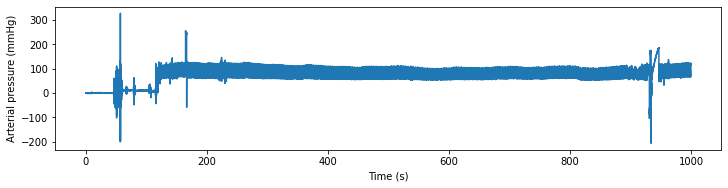

In [33]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

## Find troughs in the waveform

In [34]:
wf = find_troughs(wf, name='pressure')

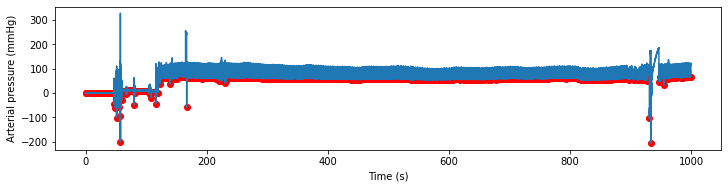

In [35]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)
ax.plot(data.time, data.pressure)
ax.scatter(
    data.time[wf.features.waveform['pressure']['troughs']],
    data.pressure[wf.features.waveform['pressure']['troughs']],
    color='red',
)
ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

## Assess signal quality

In [36]:
checked = check_cycles(wf, "pressure")

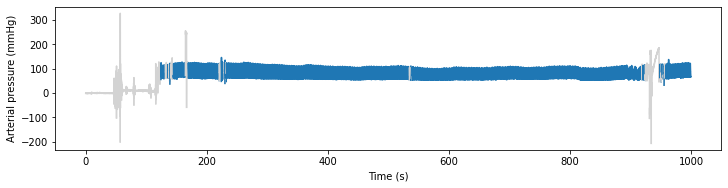

In [42]:
fig, ax = plt.subplots(figsize=(10, 2.5), constrained_layout=True)

for cycle_i, cycle in enumerate(get_cycles(wf, "pressure")):
    if checked.loc[cycle_i, 'all'].squeeze():
        colour='tab:blue'
    else:
        colour='lightgray'
    ax.plot(cycle.time, cycle.pressure, c=colour)

ax.set(xlabel='Time (s)', ylabel='Arterial pressure (mmHg)')
plt.show()

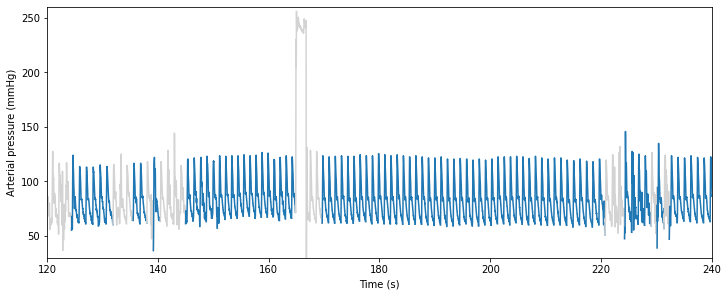

In [46]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)

for cycle_i, cycle in enumerate(get_cycles(wf, "pressure")):
    if checked.loc[cycle_i, 'all'].squeeze():
        colour='tab:blue'
    else:
        colour='lightgray'
    ax.plot(cycle.time, cycle.pressure, c=colour)

ax.set(
    xlabel='Time (s)',
    ylabel='Arterial pressure (mmHg)',
    xlim=(120, 240),
    ylim=(30, 260)
)
plt.show()